In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from functools import partial
import os
import pickle as pkl
from collections.abc import MutableMapping
import time
from typing import Any, Callable, Iterable, Mapping, Optional, Union
import json

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
import tqdm
from IPython.display import HTML

os.environ["CUDA_VISIBLE_DEVICES"] = "6"

import jax
from jax import vmap, lax
import jax.numpy as jnp
from jax.example_libraries import optimizers

# import flax
# from flax import linen as nn
# import optax
from frozendict import frozendict

import jraph
from jraph._src import graph as gn_graph
from jraph._src import utils

print(f'Jax: CPUs={jax.local_device_count("cpu")} - GPUs={jax.local_device_count("gpu")}')

Jax: CPUs=1 - GPUs=1


In [2]:
%cd ..

/home/hcduc/projects/bpignn


In [3]:
from hgnn.noisify import add_noise_and_truncate
from hgnn.model import *
from hgnn.hamiltonian import *
from hgnn.training import *
from hgnn.simulating import *

In [4]:
prefix = 'pendulum-n3'
noise_scale = 0.01
truncate_decimal = 2

Zs_train = jnp.load(f'./data/{prefix}/Zs_train.npy')
Zs_dot_train = jnp.load(f'./data/{prefix}/Zs_dot_train.npy')
Zs_test = jnp.load(f'./data/{prefix}/Zs_test.npy')
Zs_dot_test = jnp.load(f'./data/{prefix}/Zs_dot_test.npy')

Zs_train, Zs_dot_train = add_noise_and_truncate(Zs_train, Zs_dot_train, 
                                                scale=noise_scale, 
                                                decimals=truncate_decimal)

N2, dim = Zs_train.shape[-2:]
N = N2 // 2
species = jnp.zeros(N, dtype=int)
masses = jnp.ones(N)

Zs = Zs_train.reshape(-1, N2, dim)
Zs_dot = Zs_dot_train.reshape(-1, N2, dim)

Zst = Zs_test.reshape(-1, N2, dim)
Zst_dot = Zs_dot_test.reshape(-1, N2, dim)

print('N2:', N2)
print('dim:', dim)
print('Zs.shape:', Zs.shape)
print('Zs_dot.shape:', Zs_dot.shape)
print('Zst.shape:', Zst.shape)
print('Zst_dot.shape:', Zst_dot.shape)
print('Zs_test.shape:', Zs_test.shape)
print()

with open(f'./data/{prefix}/param.json', 'r') as f:
    d = json.load(f)
    stride = d['stride']
    dt = d['dt']
    lr = d['lr']
    batch_size = d['batch_size']
    epochs = d['epochs']
    
print('stride:', stride)
print('dt:', dt)
print('lr:', lr)
print('batch_size:', batch_size)
print('epochs:', epochs)

N2: 6
dim: 2
Zs.shape: (7500, 6, 2)
Zs_dot.shape: (7500, 6, 2)
Zst.shape: (2500, 6, 2)
Zst_dot.shape: (2500, 6, 2)
Zs_test.shape: (25, 100, 6, 2)

stride: 1000
dt: 1e-05
lr: 0.01
batch_size: 100
epochs: 2000


In [5]:
def pendulum_connections(P):
    return (jnp.array([i for i in range(P-1)] + [i for i in range(1, P)], dtype=int),
            jnp.array([i for i in range(1, P)] + [i for i in range(P-1)], dtype=int))

def edge_order(P):
    N = (P-1)
    return jnp.array(jnp.hstack([jnp.array(range(N, 2*N)), jnp.array(range(N))]), dtype=int)

senders, receivers = pendulum_connections(N)
eorder = edge_order(N)

In [6]:
params = jnp.load('results/pendulum-n3/dropout_0.0/params.npy', allow_pickle=True).item()

In [7]:
key = jax.random.PRNGKey(42)

Ef = 1  # eij dim
Oh = 1

Eei = 5
Nei = 5

hidden = 5
nhidden = 2

In [7]:
params = generate_HGNN_params(Oh, Nei, Ef, Eei, dim, hidden, nhidden, key)

In [8]:
R, V = jnp.split(Zs[0], 2, axis=0)

# change dropout_rate=0. to turn dropout off
apply_fn = energy_fn(
    senders=senders, receivers=receivers, species=species, R=R, V=V, eorder=eorder, dropout_rate=0.)
Hmodel = generate_Hmodel(apply_fn)


def phi(x):
    X = jnp.vstack([x[:1, :]*0, x])
    return jnp.square(X[:-1, :] - X[1:, :]).sum(axis=1) - 1.0

constraints = get_constraints(N, dim, phi)

zdot_model, lamda_force_model = get_zdot_lambda(
    N, dim, hamiltonian=Hmodel, drag=None, 
    constraints=constraints, 
    external_force=None)


v_zdot_model = vmap(zdot_model, in_axes=(0, 0, None))

Training ...


/tmp/ipykernel_565912/1988181674.py:28: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch in tqdm.tnrange(epochs):


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 100/2000 Loss (MSE):  train=0.4662710726261139, test=0.273578941822052
Epoch: 200/2000 Loss (MSE):  train=0.30549752712249756, test=0.009443601593375206
Epoch: 300/2000 Loss (MSE):  train=0.2815346419811249, test=0.005256569478660822
Epoch: 400/2000 Loss (MSE):  train=0.275095671415329, test=0.00498573062941432
Epoch: 500/2000 Loss (MSE):  train=0.2635975480079651, test=0.0050746602937579155
Epoch: 600/2000 Loss (MSE):  train=0.26353830099105835, test=0.007044991012662649
Epoch: 700/2000 Loss (MSE):  train=0.2630913555622101, test=0.007129726465791464
Epoch: 800/2000 Loss (MSE):  train=0.26280447840690613, test=0.007187011651694775
Epoch: 900/2000 Loss (MSE):  train=0.2625996172428131, test=0.007189056370407343
Epoch: 1000/2000 Loss (MSE):  train=0.2624424397945404, test=0.00714357104152441
Epoch: 1100/2000 Loss (MSE):  train=0.2623153030872345, test=0.007039923220872879
Epoch: 1200/2000 Loss (MSE):  train=0.26220977306365967, test=0.006897234357893467
Epoch: 1300/2000 Loss (MSE

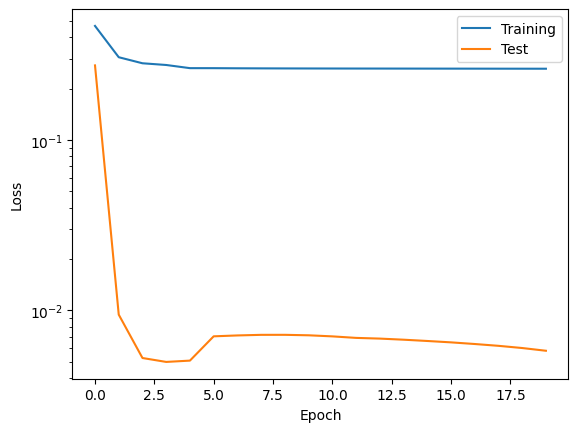

In [9]:
loss_fn = generate_loss_fn(v_zdot_model=v_zdot_model)
gloss = generate_gloss(loss_fn=loss_fn)

opt_init, opt_update_, get_params = optimizers.adam(lr)

opt_update = generate_opt_update_wrapper(opt_update_=opt_update_)

step = generate_update_fn(gloss=gloss, opt_update=opt_update, get_params=get_params)

Rs, Vs = jnp.split(Zs, 2, axis=1)
Rst, Vst = jnp.split(Zst, 2, axis=1)

bRs, bVs, bZs_dot = batching(Rs, Vs, Zs_dot,
                            size=min(len(Rs), batch_size))

print(f"Training ...")

# opt_state = optimiser.init(params)
opt_state = opt_init(params)

epoch = 0
optimizer_step = -1
larray = []
ltarray = []

last_loss = 1000

for epoch in tqdm.tnrange(epochs):
    l = 0.0
    for data in zip(bRs, bVs, bZs_dot):
        change_RNG()
        optimizer_step += 1
        opt_state, params, l_ = step(optimizer_step, (opt_state, params, 0), *data)
        l += l_
    l = l/len(bRs)
    if (epoch + 1) % (epochs // 20) == 0:
        # opt_state, params, l = step(
        #     optimizer_step, (opt_state, params, 0), Rs, Vs, Zs_dot)
        larray += [l]
        ltarray += [loss_fn(params, Rst, Vst, Zst_dot)]
        print(f"Epoch: {epoch + 1}/{epochs} Loss (MSE):  train={larray[-1]}, test={ltarray[-1]}")
    
params = get_params(opt_state)

fig, axs = plt.subplots(1, 1)
plt.semilogy(larray, label="Training")
plt.semilogy(ltarray, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# num_samples = 100

# all_traj = []

# # we won't use all tests
# # test_count = Zs_test.shape[0]
# test_count = 10
# # Running for more periods than provided dataset
# runs = 200

# sim_model = get_forward_sim(params=params, zdot_model=zdot_model, runs=runs, stride=stride, dt=dt, tol=1e-5)

# pbar = tqdm.tnrange(test_count * num_samples)

# for idx in range(test_count):
    
#     pbar.set_description(f'Test {idx+1} of {test_count}')

#     z_actual_out = Zs_test[idx]
#     x_act_out, p_act_out = jnp.split(z_actual_out, 2, axis=1)

#     Zs_init = Zs_test[idx:idx+1, 0:1]

#     with jax.default_device(jax.devices('cpu')[0]):
#         trajectories = {
#             'pred_pos': [],
#             'pred_vel': [],
#             'actual_pos': jnp.array(x_act_out),
#             'actual_vel': jnp.array(p_act_out),
#         }

#     for i in range(num_samples):

#         change_RNG()

#         Zs_noisy = add_noise_and_truncate(Zs_init, Zs_init, scale=noise_scale)[0].squeeze((0, 1))
#         R_noisy = Zs_noisy[:N]
#         V_noisy = Zs_noisy[N:]

# #         R_noisy = Zs_init.squeeze((0, 1))[:N]
# #         V_noisy = Zs_init.squeeze((0, 1))[N:]

#         z_pred_out = sim_model(R_noisy, V_noisy)
#         x_pred_out, p_pred_out = jnp.split(z_pred_out, 2, axis=1)

#         with jax.default_device(jax.devices('cpu')[0]):
#             trajectories['pred_pos'].append(x_pred_out)
#             trajectories['pred_vel'].append(p_pred_out)
            
#         pbar.update()
        
#     with jax.default_device(jax.devices('cpu')[0]):
#         trajectories['pred_pos'] = jnp.array(trajectories['pred_pos'])
#         trajectories['pred_vel'] = jnp.array(trajectories['pred_vel'])
#         trajectories['pred_pos_avg'] = jnp.mean(trajectories['pred_pos'], axis=0)
#         trajectories['pred_vel_avg'] = jnp.mean(trajectories['pred_vel'], axis=0)
    
#     all_traj.append(trajectories)

In [30]:
num_samples = 100


# Running for more periods than provided dataset
runs = 100

sim_model = get_forward_sim(params=params, zdot_model=zdot_model, runs=runs, stride=stride, dt=dt, tol=1e-5)

idx = 4

z_actual_out = Zs_test[idx]
x_act_out, p_act_out = jnp.split(z_actual_out, 2, axis=1)

Zs_init = Zs_test[idx:idx+1, 0:1]

# with jax.default_device(jax.devices('cpu')[0]):
trajectories = {
    'pred_pos': [],
    'pred_vel': [],
    'actual_pos': jnp.array(x_act_out),
    'actual_vel': jnp.array(p_act_out),
}

for i in range(num_samples):

    change_RNG()

    Zs_noisy = add_noise_and_truncate(Zs_init, Zs_init, scale=noise_scale)[0].squeeze((0, 1))
    R_noisy = Zs_noisy[:N]
    V_noisy = Zs_noisy[N:]

#         R_noisy = Zs_init.squeeze((0, 1))[:N]
#         V_noisy = Zs_init.squeeze((0, 1))[N:]

    z_pred_out = sim_model(R_noisy, V_noisy)
    x_pred_out, p_pred_out = jnp.split(z_pred_out, 2, axis=1)

    # with jax.default_device(jax.devices('cpu')[0]):
    trajectories['pred_pos'].append(x_pred_out)
    trajectories['pred_vel'].append(p_pred_out)
        
    
# with jax.default_device(jax.devices('cpu')[0]):
trajectories['pred_pos'] = jnp.array(trajectories['pred_pos'])
trajectories['pred_vel'] = jnp.array(trajectories['pred_vel'])
trajectories['pred_pos_avg'] = jnp.mean(trajectories['pred_pos'], axis=0)
trajectories['pred_vel_avg'] = jnp.mean(trajectories['pred_vel'], axis=0)



In [16]:
with open('./results/pendulum-n3-plain.pkl', 'wb+') as f:
    pkl.dump(all_traj, f)

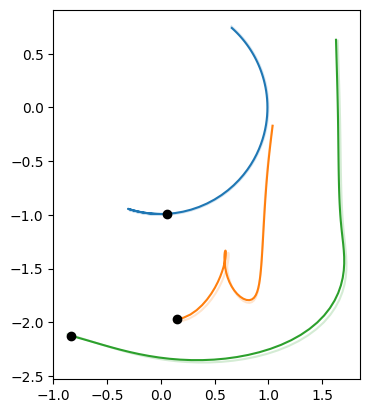

In [31]:
# idx = 0

# trajectories = all_traj[idx]

r = trajectories['actual_pos']
for i in range(r.shape[1]):
    plt.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}', alpha=0.2)
# plt.plot(r[-1,:,0], r[-1,:,1], 'o', color='black', alpha=0.1)

r = trajectories['pred_pos'][100]
for i in range(r.shape[1]):
    plt.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}', alpha=1.)
plt.plot(r[-1,:,0], r[-1,:,1], 'o', color='black', alpha=1.)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [29]:
trajectories['pred_pos'].shape

(100, 200, 3, 2)

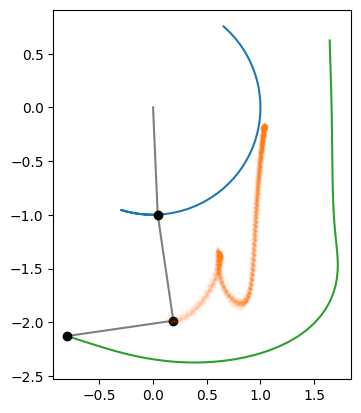

In [32]:
i_err = 1

# r = trajectories['actual_pos']
# for i in range(r.shape[1]):
#     plt.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}', alpha=0.2)
    
# plt.plot(r[-1,:,0], r[-1,:,1], 'o', color='black', alpha=0.1)

r = trajectories['pred_pos_avg']
for i in range(r.shape[1]):
    if i != i_err:
        plt.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}')

plt.plot([0] + list(r[-1,:,0]), [0] + list(r[-1,:,1]), '-', color='gray', alpha=1.)
plt.plot(r[-1,:,0], r[-1,:,1], 'o', color='black')

r = trajectories['pred_pos']
for t in range(r.shape[1]):
    plt.plot(r[:,t,i_err,0], r[:,t,i_err,1], '.', color=f'C{i_err}', 
             markerfacecolor=None, alpha=5. / num_samples, ms=1)


plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [24]:
fig, ax = plt.subplots()

# r = trajectories['actual_pos']
# traj_actual = [ax.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}', alpha=0.1)[0] for i in range(r.shape[1])]  
# ball_actual, = ax.plot(r[-1,:,0], r[-1,:,1], 'o', color='black', alpha=0.1)

r = trajectories['pred_pos_avg']
traj_pred = [ax.plot(r[:,i,0], r[:,i,1], '-', color=f'C{i}', alpha=1.)[0] for i in range(r.shape[1])]  
ball_pred, = ax.plot(r[-1,:,0], r[-1,:,1], 'o', color='black', alpha=0.5, zorder=5.)
rods_pred, = ax.plot([0] + list(r[-1,:,0]), [0] + list(r[-1,:,1]), '-', color='gray', alpha=1.)

r = trajectories['pred_pos']
point_cloud = [ax.plot(r[:,0,i,0], r[:,0,i,1], 'o', color=f'C{i}', 
                       alpha=2. / num_samples, zorder=4., markerfacecolor=None)[0] 
               for i in range(r.shape[2])]  

def gather():
#     return traj_actual + [ball_actual] + traj_pred + [ball_pred]
    return point_cloud + traj_pred + [rods_pred,ball_pred]

def init():
    ax.set_aspect('equal', adjustable='box')
    return gather()

def update(frame):
    
#     r = trajectories['actual_pos']
#     for i in range(r.shape[1]):
#         traj_actual[i].set_data(r[:frame,i,0], r[:frame,i,1])
#     ball_actual.set_data(r[frame,:,0], r[frame,:,1])

    r = trajectories['pred_pos_avg']
    for i in range(r.shape[1]):
        traj_pred[i].set_data([], [])
    ball_pred.set_data(r[frame,:,0], r[frame,:,1])
    rods_pred.set_data([0] + list(r[frame,:,0]), [0] + list(r[frame,:,1]))
    
    r = trajectories['pred_pos']
    for i in range(r.shape[2]):
        point_cloud[i].set_data(r[:,frame,i,0], r[:,frame,i,1])
    
    return gather()

ani = FuncAnimation(fig, update, frames=tqdm.tnrange(runs), init_func=init, blit=True, interval=20)
plt.close(fig)
HTML(ani.to_jshtml())

/tmp/ipykernel_565912/781598445.py:44: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  ani = FuncAnimation(fig, update, frames=tqdm.tnrange(runs), init_func=init, blit=True, interval=20)


  0%|          | 0/200 [00:00<?, ?it/s]

In [25]:
writergif = PillowWriter(fps=30, bitrate=300) 
ani.save(f'./demo/pendulum-n3-plain-{idx}.gif', writer=writergif)